In [1]:
import math
import pickle
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

import mesa
from mesa.model import Model
from abm_network.model import VirusOnNetwork
from abm_network.parameters import analysis_params_a
from abm_network.constants import State
from abm_network.rule_functions import *
from abm_network.agents import MalwareAgent
from abm_network.analysis import regenerate_network, get_clusters, get_clustering_coefficient

## Run simulation

In [87]:
# Cluster distribution 1
cluster_analysis_params = {
    "num_nodes": 100, # 100
    "avg_node_degree": 3, # 3
    "initial_outbreak_size": 1, # 1
    "centrality": "degree", # degree
    "malware_spread_chance": 0.4, # 0.4
    "malware_check_frequency":  0.4,  # 0.4[, 0.1, 0.8]
    "recovery_chance":  0.4,
    "gain_resistance_chance": gain_resistance_chance,
    "importance": importance_degree,
    "susceptible_chance":  susceptible_chance,
    "death_chance":  death_chance,
    "network": "Erdos-Renyi",
}
n_run = 100

In [85]:
results = mesa.batch_run(
    VirusOnNetwork,
    parameters=cluster_analysis_params,
    iterations=n_run,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100it [02:13,  1.34s/it]


In [86]:
with open("cluster_distribution_3.p", "wb") as fp:
    pickle.dump(results, fp)

## Visualize distribution of clusters size

Load data

In [122]:
data = pd.DataFrame(pickle.load(open("./data/cluster_distribution_3.p", "rb" )))

In [91]:
data[(data.RunId == 0)]

,RunId,iteration,Step,num_nodes,avg_node_degree,initial_outbreak_size,centrality,malware_spread_chance,malware_check_frequency,recovery_chance,...,death_chance,network,Infected,Susceptible,Resistant,Offline,Death,Clusters,Ccoeff,Cluster_distribution
0,0,0,0,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,1,99,0,0,0,13,0.031952,"(([9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,0,0,1,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,4,94,0,2,0,15,0.020476,"(([11, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,0,2,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,7,86,0,7,0,20,0.020476,"(([16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,3,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,13,78,0,9,0,25,0.020476,"(([19, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,0,0,4,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,17,73,1,9,0,23,0.020476,"(([18, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,0,96,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,0,72,27,0,1,14,0.031952,"(([10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
97,0,0,97,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,0,72,27,0,1,14,0.031952,"(([10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
98,0,0,98,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,0,73,26,0,1,14,0.031952,"(([10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
99,0,0,99,100,3,1,degree,0.4,0.4,0.4,...,<function death_chance at 0x116922200>,Erdos-Renyi,0,73,26,0,1,14,0.031952,"(([10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [104]:
def extend_hist(hist, local_range, global_range):
    nhist = np.zeros(global_range)
    nhist[local_range[0] - 1:local_range[1]] = hist
    return nhist

In [117]:
def data_processing(results_df, n_run):
    x = []
    y = []
    z = []

    sim_cc_max = 1
    for run_id in range(n_run):
        cluster_distribution = results_df[(results_df.RunId == run_id)]["Cluster_distribution"]
        for _, (_, cc_max) in cluster_distribution:
            sim_cc_max = max(sim_cc_max, cc_max)

    for run_id in range(n_run):
        cluster_distribution = results_df[(results_df.RunId == run_id)]["Cluster_distribution"]
        susceptible = np.array(results_df[(results_df.RunId == run_id)]["Susceptible"])
        infected = np.array(results_df[(results_df.RunId == run_id)]["Infected"])
        resistant = np.array(results_df[(results_df.RunId == run_id)]["Resistant"])
        offline = np.array(results_df[(results_df.RunId == run_id)]["Offline"])
        death = np.array(results_df[(results_df.RunId == run_id)]["Death"])

        # === Initialize ===
        n_sim = len(cluster_distribution)
        sim_nhist = []
        sim_avg = dict()
        avg_hist = dict()

        # Get infected count
        k, v = np.unique(offline, return_counts=True)
        sim_count = dict(zip(k, v))

        nbins = list(range(1, sim_cc_max + 1, 1))

        for j in sim_count.keys():
            sim_avg[j] = np.zeros(sim_cc_max)

        # === Process data ====
        for i, (tupl, interval) in enumerate(cluster_distribution):
            hist, bins = tupl
            j = offline[i]
            n_clusters = sum(hist) # - j
            nhist = extend_hist(hist, interval, sim_cc_max)
            # nhist[0] -= j
            single_clusters = nhist[0]
            nhist[0] = 0
            sim_avg[j] += (nhist / (n_clusters - single_clusters))

        for k in sim_avg.keys(): # change dict sim_avg and sim_count to get missing keys. Replace by array
            avg_hist[k] = sim_avg[k] / sim_count[k] # Generate 3d points infected-cluster_size-average_number_cluster_of_this_size

        for inf, his in avg_hist.items():
            for c, dis in enumerate(his):
                clu = nbins[c]
                if dis > 0: # and clu > 1:
                    x.append(inf)
                    y.append(clu)
                    z.append(dis)

    xs = np.array(x)
    ys = np.array(y)
    zs = np.array(z)
    
    return xs, ys, zs

In [123]:
xs, ys, zs = data_processing(data, n_run)

<IPython.core.display.Javascript object>


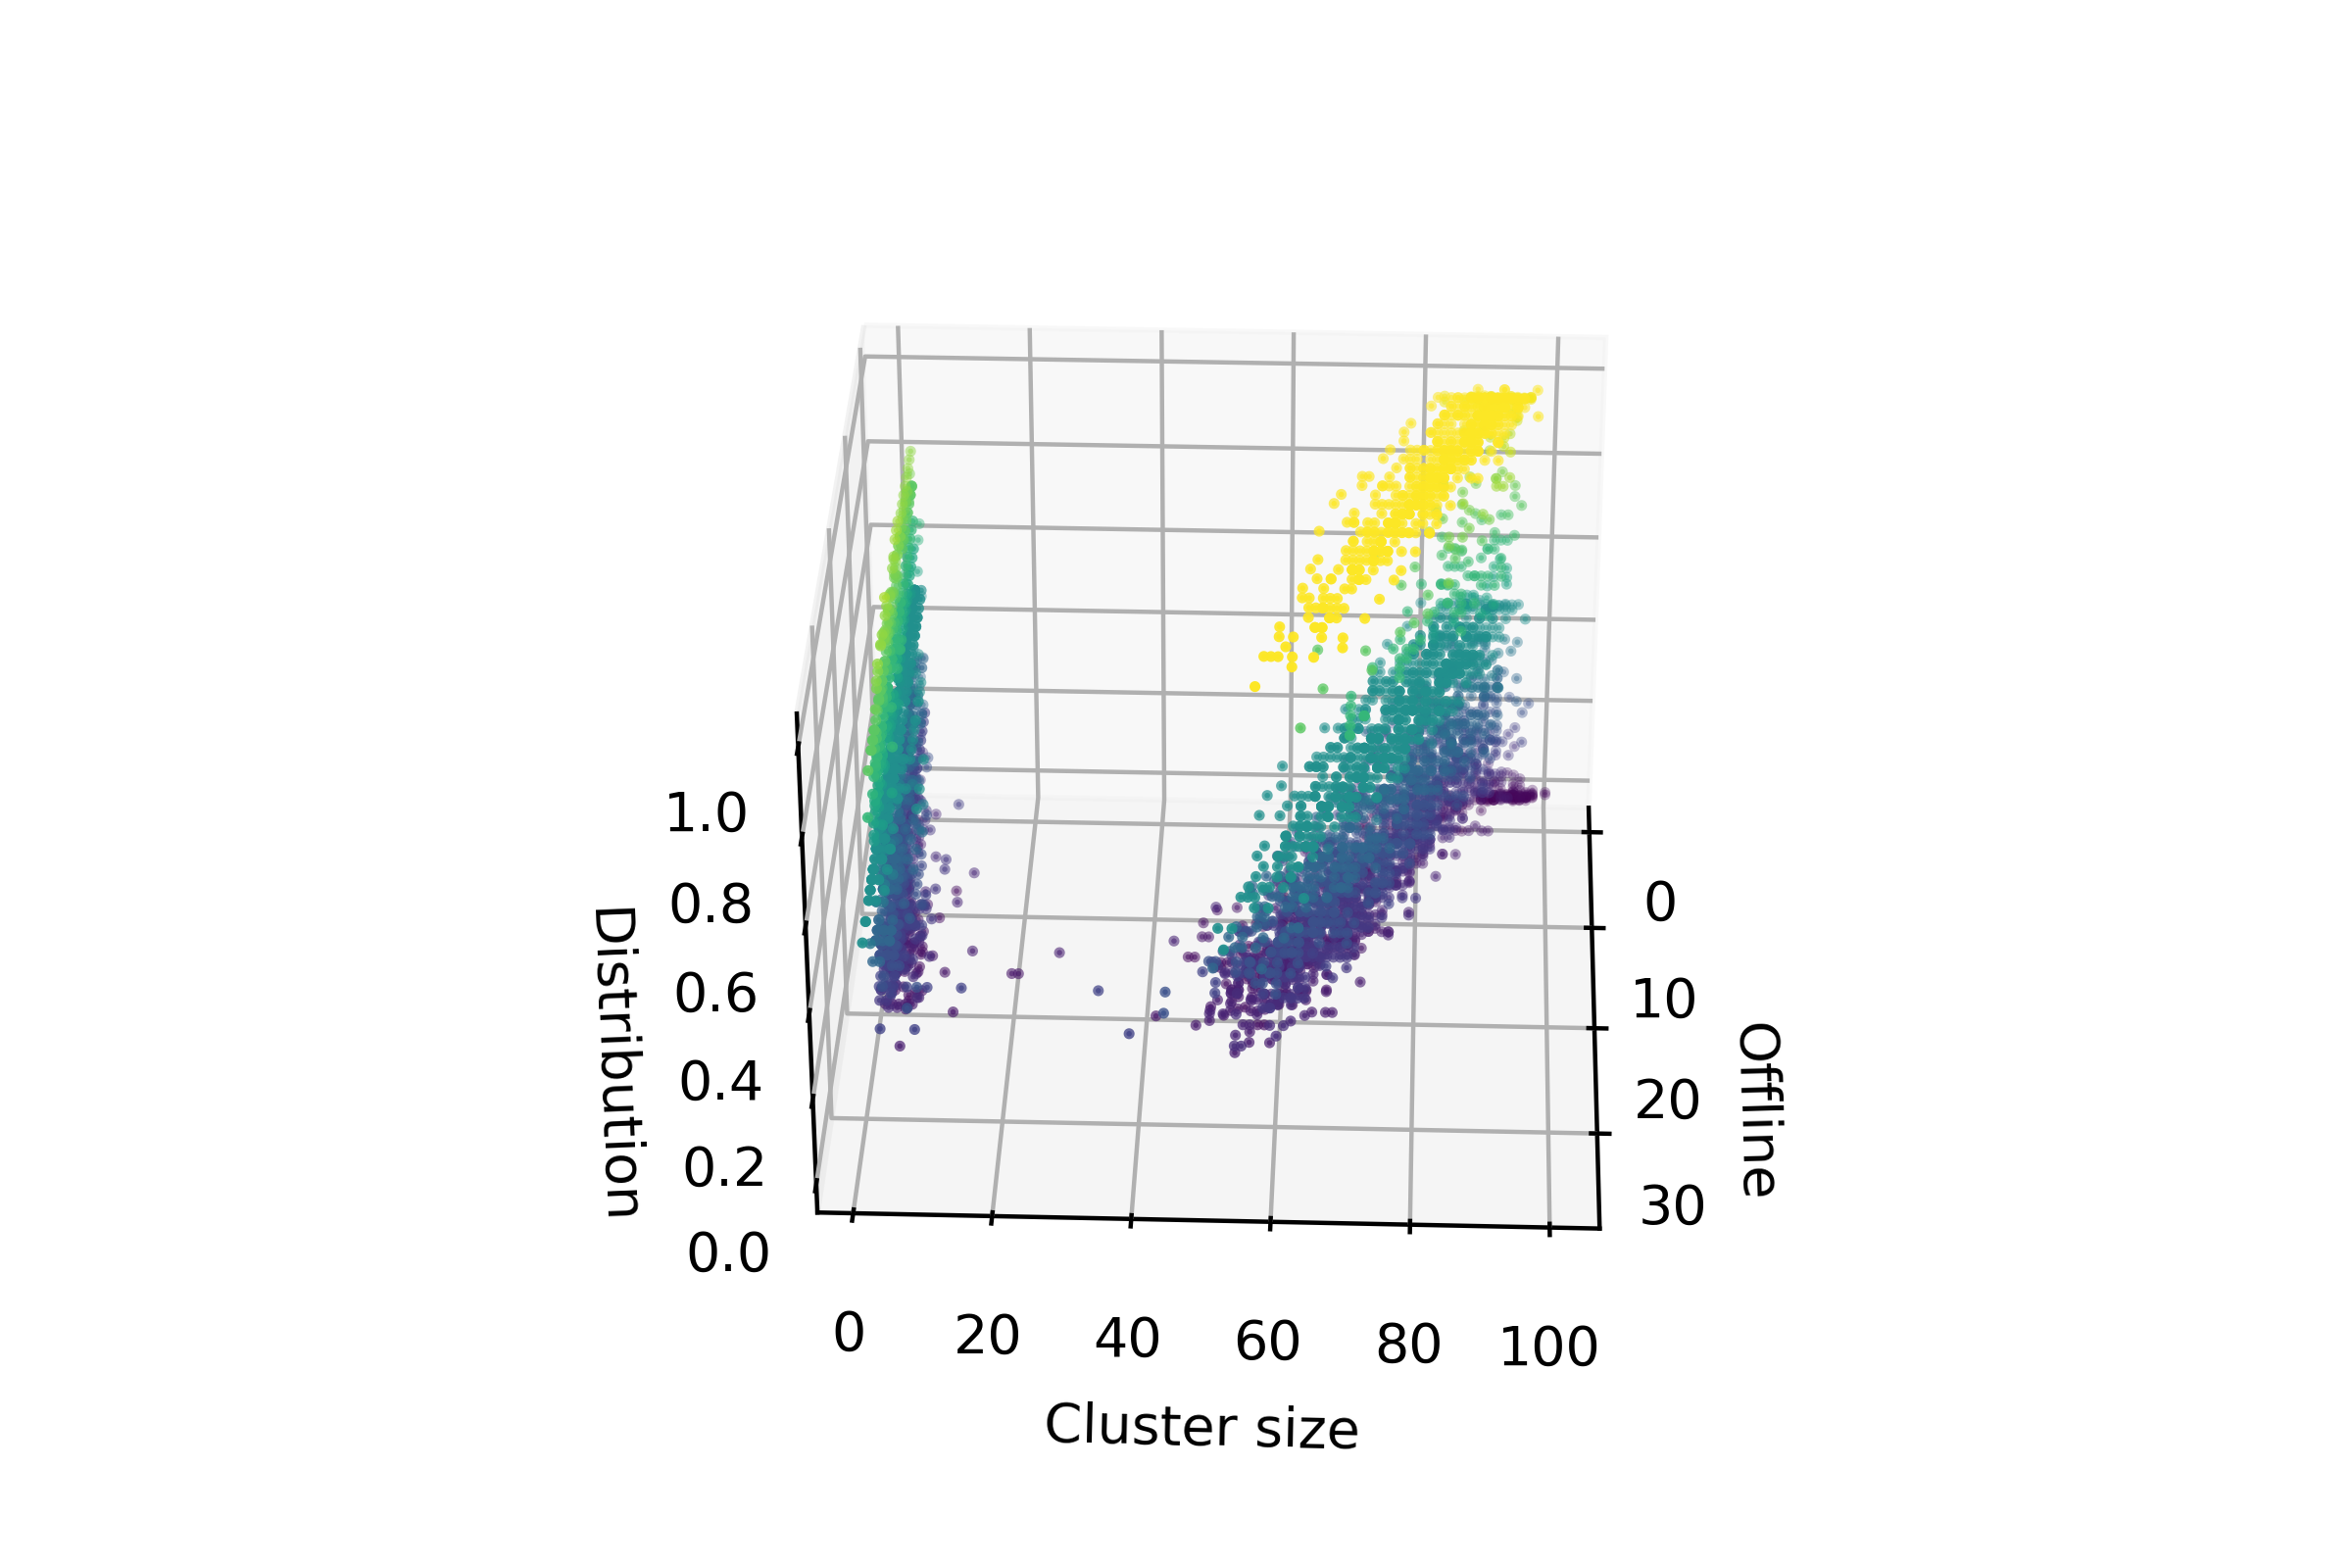

Text(0.5, 0, 'Distribution')

In [124]:
%matplotlib notebook

fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c=zs, marker='o', s=1)

ax.set_xlabel("Offline")
ax.set_ylabel("Cluster size")
ax.set_zlabel("Distribution")

<IPython.core.display.Javascript object>


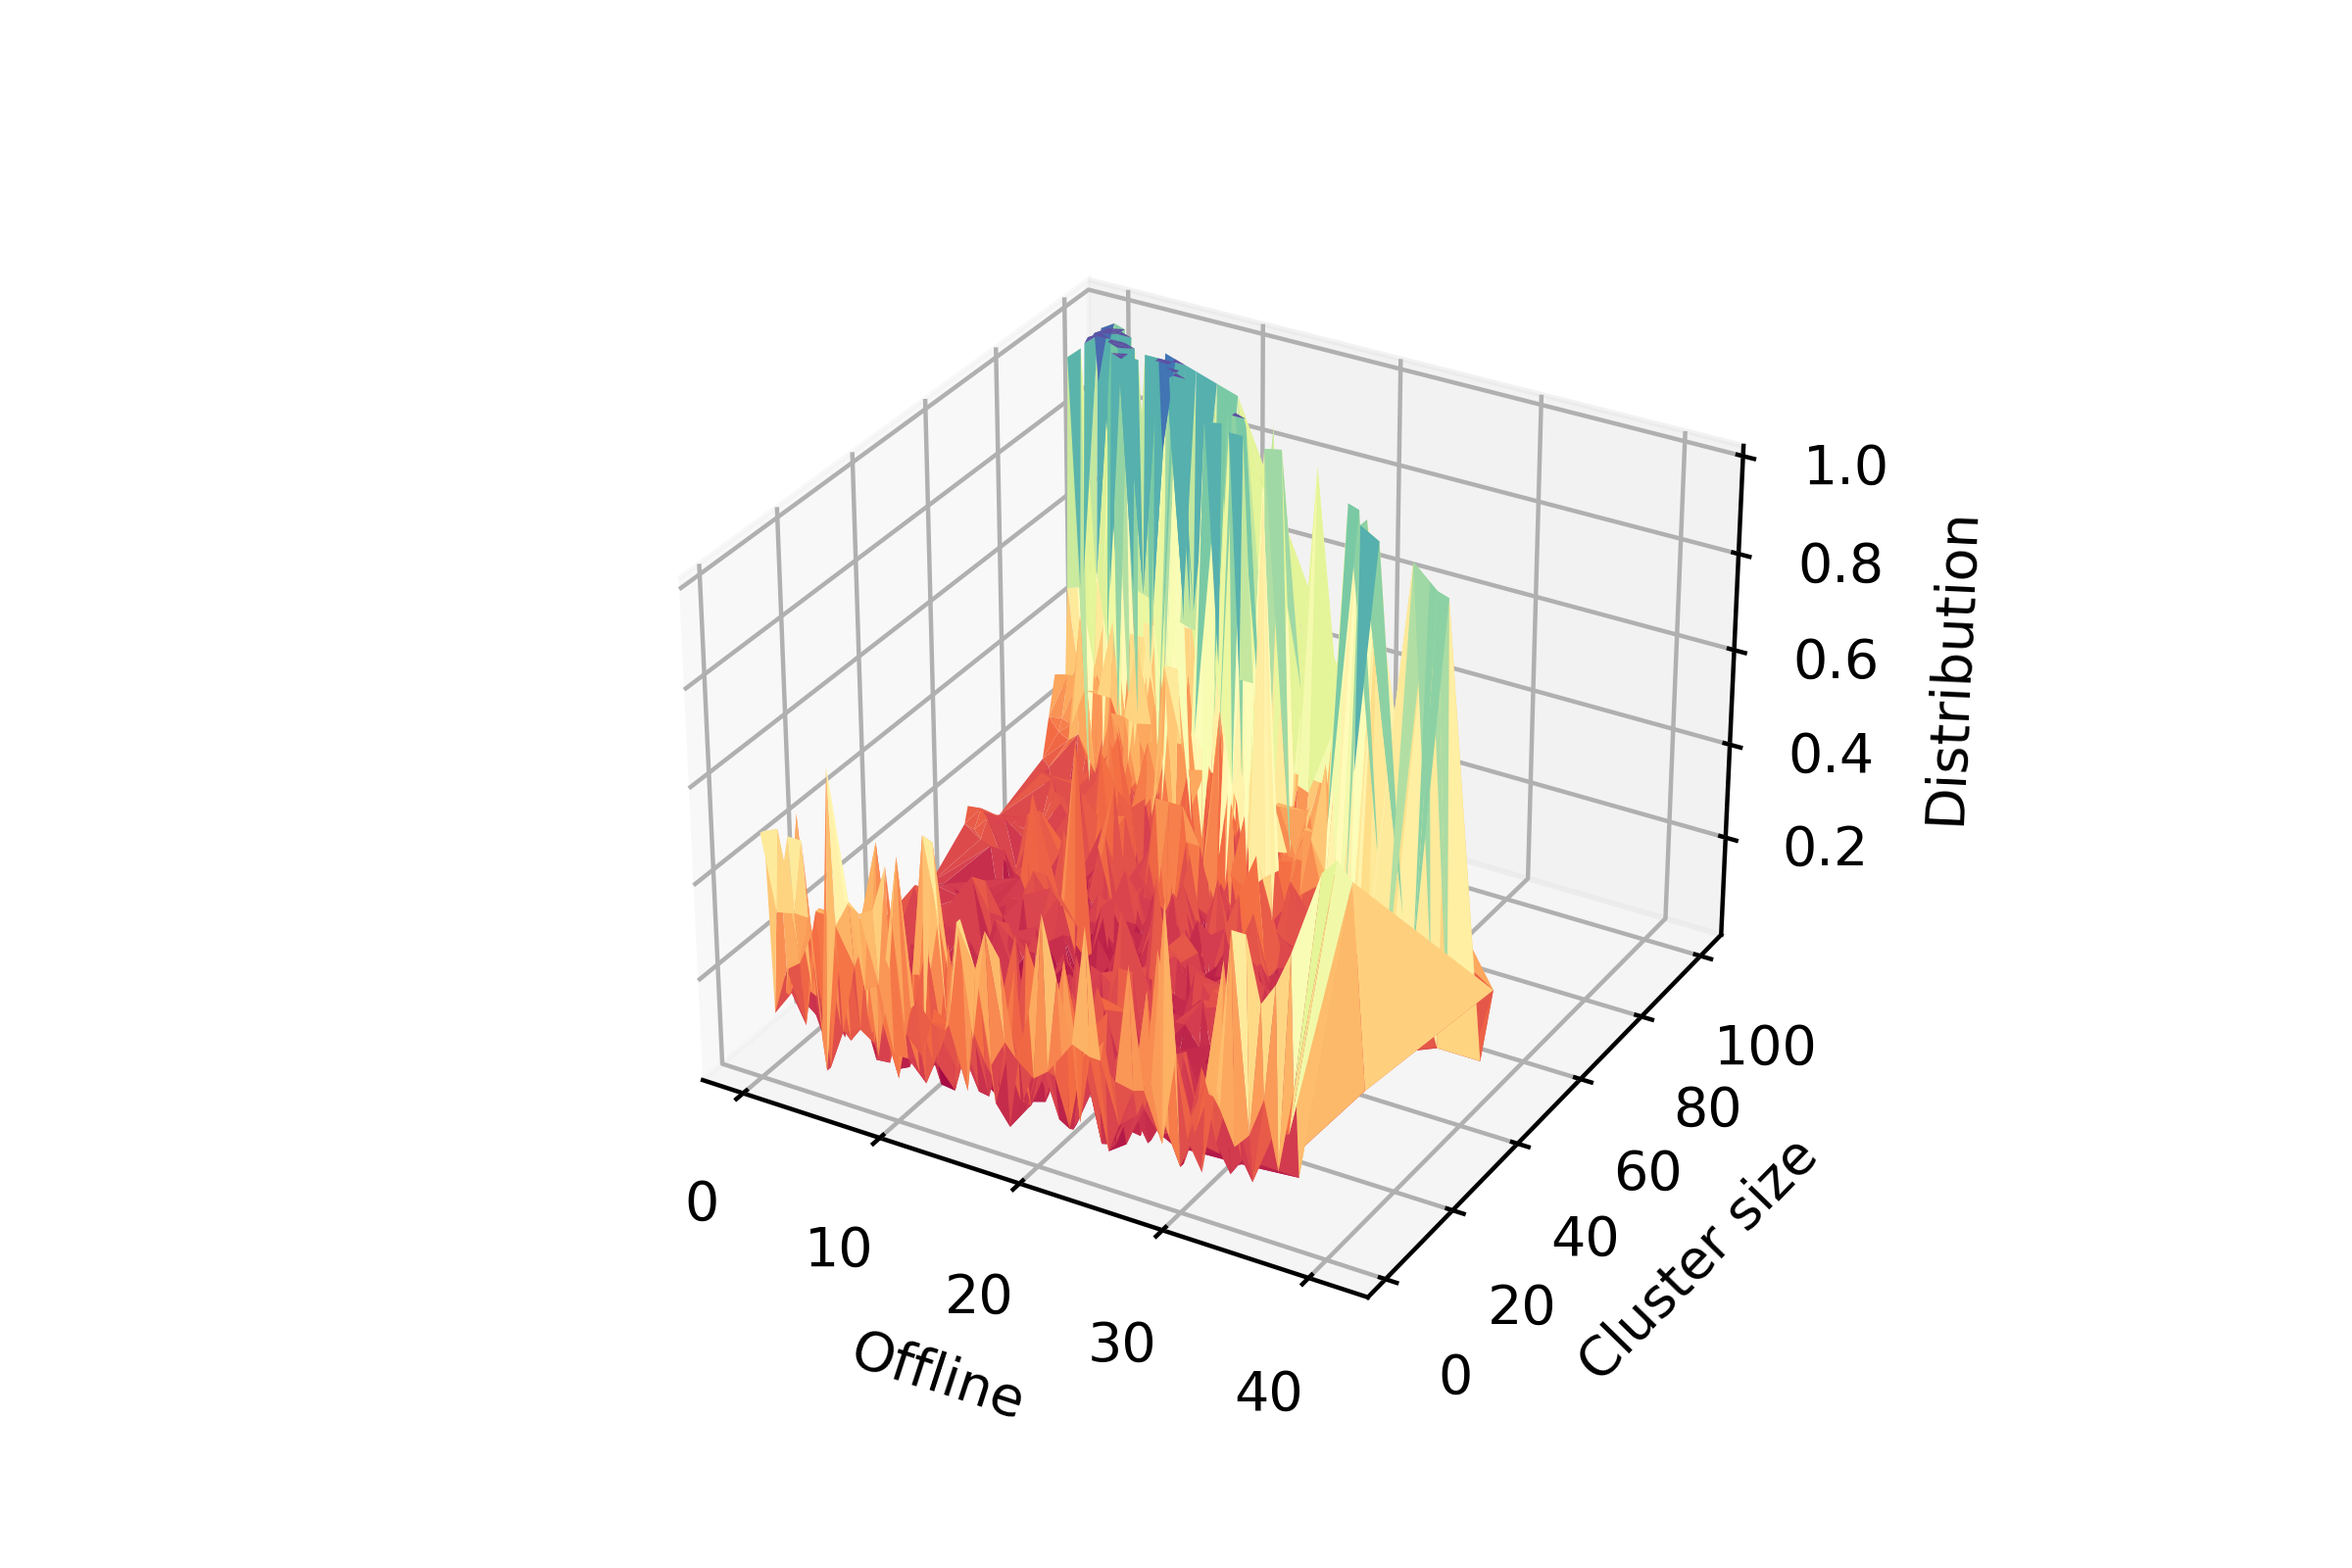

Text(0.5, 0, 'Distribution')

In [120]:
%matplotlib notebook

fig2 = plt.figure(dpi=200)
ax2 = fig2.add_subplot(projection='3d')
ax2.plot_trisurf(xs, ys, zs, cmap=plt.cm.Spectral)

ax2.set_xlabel("Offline")
ax2.set_ylabel("Cluster size")
ax2.set_zlabel("Distribution")

## Analyse number of avalanche compare to S,I,R,O,D

In [ ]:
nb_clusters = results_df[(results_df.RunId == 0)]["Cluster_distribution"]